In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
!unzip Data.zip -d /content/unzipped_data

Streaming output truncated to the last 5000 lines.
 extracting: /content/unzipped_data/Data/5/img006-00085.png  
 extracting: /content/unzipped_data/Data/5/img006-00086.png  
 extracting: /content/unzipped_data/Data/5/img006-00087.png  
 extracting: /content/unzipped_data/Data/5/img006-00088.png  
 extracting: /content/unzipped_data/Data/5/img006-00089.png  
 extracting: /content/unzipped_data/Data/5/img006-00090.png  
 extracting: /content/unzipped_data/Data/5/img006-00091.png  
 extracting: /content/unzipped_data/Data/5/img006-00092.png  
 extracting: /content/unzipped_data/Data/5/img006-00093.png  
 extracting: /content/unzipped_data/Data/5/img006-00094.png  
 extracting: /content/unzipped_data/Data/5/img006-00095.png  
 extracting: /content/unzipped_data/Data/5/img006-00096.png  
 extracting: /content/unzipped_data/Data/5/img006-00097.png  
 extracting: /content/unzipped_data/Data/5/img006-00098.png  
 extracting: /content/unzipped_data/Data/5/img006-00099.png  
 extracting: /conte

In [7]:
# Get the data
classes = 10
images = []
labels = []

# Update the path to the correct folder
data_path = '/content/unzipped_data/Data/'

for i in range(0, classes):
    imgList = os.listdir(data_path + str(i))
    for j in imgList:
        currentImg = cv2.imread(data_path + str(i) + '/' + str(j))
        currentImg = cv2.resize(currentImg, (28, 28))
        images.append(currentImg)
        labels.append(i)

In [8]:
print(len(images))
print(len(labels))

10160
10160


In [9]:
images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(10160, 28, 28, 3)
(10160,)


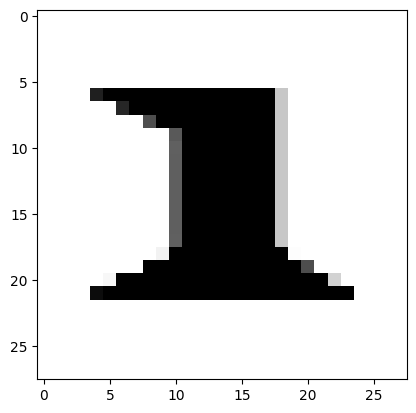

In [10]:
plt.imshow(images[2000])

In [11]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)
print(train_images.shape)
print(test_images.shape)

(8128, 28, 28, 3)
(2032, 28, 28, 3)


In [12]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)
print(train_images.shape)
print(val_images.shape)

(6502, 28, 28, 3)
(1626, 28, 28, 3)


## Preprocessing the data

In [13]:
def preProcess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = img / 255
    return img

train_images = np.array(list(map(preProcess, train_images)))
test_images = np.array(list(map(preProcess, test_images)))
val_images = np.array(list(map(preProcess, val_images)))

In [14]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(6502, 28, 28)
(2032, 28, 28)
(1626, 28, 28)


In [15]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
val_images = val_images.reshape(val_images.shape[0], 28, 28, 1)

In [16]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(6502, 28, 28, 1)
(2032, 28, 28, 1)
(1626, 28, 28, 1)


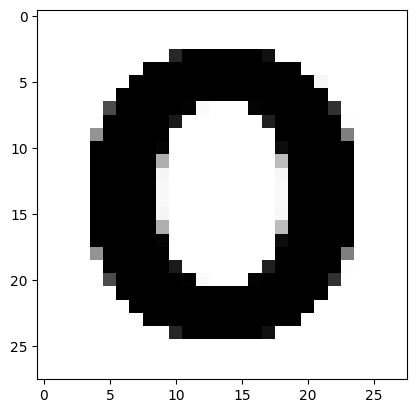

In [17]:
plt.imshow(images[200])

## Defining Callback

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

## Creating CNN Model

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28, 28, 1), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 64)         

## Image Augmentation

In [21]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

## Training the model

In [22]:
callbacks = myCallback()
history = model.fit(datagen.flow(train_images, train_labels),
                              epochs = 30, validation_data = (val_images, val_labels), callbacks = [callbacks])



Epoch 1/30
204/204 [==============================] - 14s 63ms/step - loss: 1.8913 - accuracy: 0.3179 - val_loss: 0.4815 - val_accuracy: 0.9157
Epoch 2/30
204/204 [==============================] - 11s 52ms/step - loss: 0.7548 - accuracy: 0.7533 - val_loss: 0.1264 - val_accuracy: 0.9649
Epoch 3/30
204/204 [==============================] - 8s 41ms/step - loss: 0.4657 - accuracy: 0.8491 - val_loss: 0.0851 - val_accuracy: 0.9791
Epoch 4/30
204/204 [==============================] - 10s 48ms/step - loss: 0.3539 - accuracy: 0.8890 - val_loss: 0.0607 - val_accuracy: 0.9797
Epoch 5/30
204/204 [==============================] - 11s 52ms/step - loss: 0.2837 - accuracy: 0.9100 - val_loss: 0.0577 - val_accuracy: 0.9809
Epoch 6/30
204/204 [==============================] - 8s 40ms/step - loss: 0.2535 - accuracy: 0.9200 - val_loss: 0.0392 - val_accuracy: 0.9859
Epoch 7/30
204/204 [==============================] - 11s 52ms/step - loss: 0.2214 - accuracy: 0.9279 - val_loss: 0.0499 - val_accuracy: 0

### Plotting Graphs

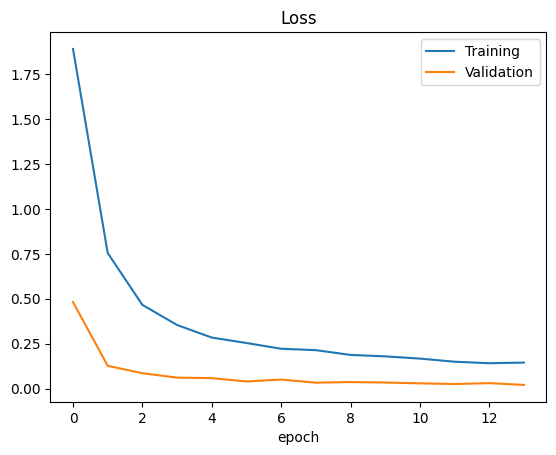

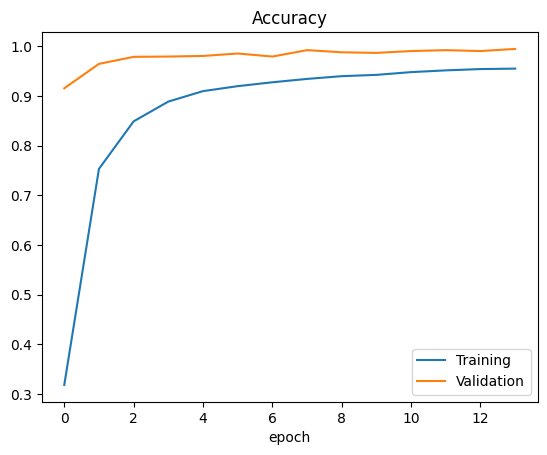

In [23]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()


### Evaluating the model on Test set

In [24]:
score = model.evaluate(test_images, test_labels, verbose=1)
print('Test Score : ', score[0])
print('Test Accuracy : ', score[1])


64/64 [==============================] - 1s 9ms/step - loss: 0.0158 - accuracy: 0.9946
Test Score :  0.015834329649806023
Test Accuracy :  0.9945865869522095


### Saving the model

In [26]:
# Create the directory if it doesn't exist
model_dir = '/content/model'
os.makedirs(model_dir, exist_ok=True)

# Save the model to the specified directory
model.save(os.path.join(model_dir, 'ocr_v2.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
